# Atividade 1

Analizar consistência, convergência e estabilidade com relação à equação da advecção

$$
\begin{cases}
  u_t + v u_x = 0, & t \in [0,1], x \in [0,1] \\
  u(0,x) = u^0(x) \\
    % \begin{cases}
    %   0, & x \in [0,\frac{1}{4}] \\
    %   1, & x \in (\frac{1}{4},\frac{1}{2}] \\
    %   0, & x \in (\frac{1}{2},1]
    % \end{cases} \\
  u(t,0) = u(t,1)
\end{cases}
$$

para os seguintes métodos:

1. Avançado no tempo e avançado no espaço
2. Avançado no tempo e retrógrado no espaço
3. Avançado no tempo e central no espaço
4. Central no tempo e central no espaço
5. Lax-Friedrichs
6. Lax-Wendroff


## Solução analítica da Equação da Advecção

$$
u_t + vu_x = 0
$$

A equação da advecção pode ser reescrita como

$$
(1, v) \cdot (u_t, u_v) = 0 \\
(1, v) \cdot\vec\nabla u= 0
$$

Ou seja, o gradiente da função $u$ aponta em uma direção ortogonal ao vetor $(1,v)$. Portanto, na direção desse vetor a função $u(t,x)$ tem valor constante. Tendo isso em mente, é possível descobrir o valor da função $u(t,x)$ em um ponto $(t,x)$ obtendo-se o valor da função em qualquer outro ponto que esteja na reta definida pelo ponto $(t,x)$ e o vetor $(1,v)$.

![image.png](https://i.imgur.com/CwfkdZi.png)

É possível observar pela imagem que o valor da função será o valor em alguma condição inicial $u(0,x) = u_0(x)$ deslocada no espaço por algum $\Delta x$, ou seja,

$$
u(t,x) = u(0, x - \Delta x) = u_0(x - \Delta x)
$$

. Para descobrir o deslocamento, basta utilizar a simetria de triângulos:

$$
\frac{1}{v} = \frac{\Delta t}{\Delta x} \\
\Delta x =  v \Delta t
$$

Portanto, para $\Delta t = t$, a solução para a equação do transporte é dada por

$$
u(t,x) = u(0, x - vt) = u_0(x - vt)
$$

Nas figuras abaixo, é apresentado um exemplo de função com dimensões $(t, x)$, com vetores indicando a direção das curvas características na qual o valor da função se mantém constante. Foi escolhida a condição inicial $u(0,x) = u_0(x) = \sin(\pi*x)$, resultando na solução $u(t,x)=u_0(x-vt) = \sin(\pi * (x-vt))$.

![image-2.png](https://i.imgur.com/HG6BBeP.png)

![image-3.png](https://i.imgur.com/9v6r56I.png)

Octave script:

```matlab
x=0:0.02:1;
t=0:0.02:1;
u=0:0.02:1;
[tt, xx] = meshgrid (t,x);
u = sin(pi*(xx-tt));
surf(xx,tt,u)
hold on
quiver3(xx(1:10:end),tt(1:10:end),u(1:10:end),
    ones(size(xx(1:10:end))), ones(size(tt(1:10:end))),
    zeros(size(u(1:10:end))))
```


## Implementação dos métodos numéricos

Para implementar os métodos, foi utilizada uma abordagem orientada a objetos, que permitiu criar diversos métodos apenas definindo uma função para atualizar o valor de $u^{n+1}_m$ a partir dos valores de $u$, e para os métodos multi-passo, outra função para inicializar o método.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass
from abc import ABC, abstractmethod
from typing import List
import pandas as pd


# np.seterr(over="ignore")


@dataclass
class DiscreteTimeDomain:
    t_0: float
    T: float
    N: int


@dataclass
class DiscreteSpaceDomain:
    a: float
    b: float
    M: int


class TransportEquationIVP(ABC):
    # How many time steps in the past are needed to calculate the next one
    # e.g.: if a method requires u_{n-1} and u_n to calculate u_{n+1}, it's time_order should be 2
    time_order: int

    @abstractmethod
    def preprocessing_step(self, n, u, v, delta_t, delta_x): ...

    @abstractmethod
    def step(self, n: int, u: np.ndarray, v: float, delta_t: float, delta_x: float): ...

    def left_boundary_condition(
        self, n: int, u: np.ndarray, v: float, delta_t: float, delta_x: float
    ):
        # Periodic boundary condition
        # Left boundary unchanged for v < 0
        if v < 0:
            return u[n + 1, 0]
        return u[n + 1, -1]

    def right_boundary_condition(
        self, n: int, u: np.ndarray, v: float, delta_t: float, delta_x: float
    ):
        # Periodic boundary condition
        # Right boundary unchanged for v > 0
        if v > 0:
            return u[n + 1, -1]
        return u[n + 1, 0]

    def solve(
        self,
        time_domain: DiscreteTimeDomain,
        space_domain: DiscreteSpaceDomain,
        v: float,
        u0: np.ndarray,
    ):
        v = v

        N = time_domain.N
        M = space_domain.M
        a = space_domain.a
        b = space_domain.b
        t_0 = time_domain.t_0
        T = time_domain.T
        delta_t = (T - t_0) / N
        delta_x = (b - a) / M

        # Initialize solution
        u = np.zeros((N + 1, M + 1))
        u[0, :] = u0

        # # Calculate preparation steps (for multiple step discretization methods)
        for n in range(self.time_order - 1):
            u[n + 1, :] = self.preprocessing_step(n, u, v, delta_t, delta_x)
            u[n + 1, 0] = self.left_boundary_condition(n, u, v, delta_t, delta_x)
            u[n + 1, -1] = self.right_boundary_condition(n, u, v, delta_t, delta_x)

        # Calculate values of u iteratively from initial condition with finite differences
        # for n in range(self.time_order - 1, N):
        for n in range(self.time_order - 1, N):
            u[n + 1, :] = self.step(n, u, v, delta_t, delta_x)
            u[n + 1, 0] = self.left_boundary_condition(n, u, v, delta_t, delta_x)
            u[n + 1, -1] = self.right_boundary_condition(n, u, v, delta_t, delta_x)

        error = (
            u[-1, :] - u0
        )  # Error: u(T, x) - u(0, x). Valid for only because v=1 and b-a = 1 and T-t_0 = 1!!!

        return u, error


class FTFS(TransportEquationIVP):
    time_order = 1

    def preprocessing_step(self, n, u, v, delta_t, delta_x): ...

    def step(self, n: int, u: np.ndarray, v: float, delta_t: float, delta_x: float):
        """Calculate u^{n+1}_m

        :param n: current time step (iteration counter)
        :type n: int
        :param u: solution array
        :type u: np.ndarray
        :param v: velocity of propagation in transport equation
        :type v: float
        :param delta_t:
        :type delta_t: float
        :param delta_x:
        :type delta_x: float
        :return: u[n+1,:]
        :rtype: np.ndarray
        """
        return u[n, :] - delta_t * v * (np.roll(u[n, :], -1) - u[n, :]) / delta_x


class FTBS(TransportEquationIVP):
    time_order = 1

    def preprocessing_step(self, n, u, v, delta_t, delta_x): ...

    def step(self, n: int, u: np.ndarray, v: float, delta_t: float, delta_x: float):
        """Calculate u^{n+1}_m

        :param n: current time step (iteration counter)
        :type n: int
        :param u: solution array
        :type u: np.ndarray
        :param v: velocity of propagation in transport equation
        :type v: float
        :param delta_t:
        :type delta_t: float
        :param delta_x:
        :type delta_x: float
        :return: u[n+1,:]
        :rtype: np.ndarray
        """
        return u[n, :] - delta_t * v * (u[n, :] - np.roll(u[n, :], 1)) / delta_x


class FTCS(TransportEquationIVP):
    time_order = 1

    def preprocessing_step(self, n, u, v, delta_t, delta_x): ...

    def step(self, n: int, u: np.ndarray, v: float, delta_t: float, delta_x: float):
        """Calculate u^{n+1}_m

        :param n: current time step (iteration counter)
        :type n: int
        :param u: solution array
        :type u: np.ndarray
        :param v: velocity of propagation in transport equation
        :type v: float
        :param delta_t:
        :type delta_t: float
        :param delta_x:
        :type delta_x: float
        :return: u[n+1,:]
        :rtype: np.ndarray
        """
        return u[n, :] - delta_t * v * (np.roll(u[n, :], -1) - np.roll(u[n, :], 1)) / (
            2 * delta_x
        )


class CTCS(TransportEquationIVP):
    time_order = 2

    def preprocessing_step(self, n, u, v, delta_t, delta_x):
        return FTBS().step(n, u, v, delta_t, delta_x)

    def step(self, n: int, u: np.ndarray, v: float, delta_t: float, delta_x: float):
        """Calculate u^{n+1}_m

        :param n: current time step (iteration counter)
        :type n: int
        :param u: solution array
        :type u: np.ndarray
        :param v: velocity of propagation in transport equation
        :type v: float
        :param delta_t:
        :type delta_t: float
        :param delta_x:
        :type delta_x: float
        :return: u[n+1,:]
        :rtype: np.ndarray
        """
        return (
            u[n - 1, :]
            - delta_t * v * (np.roll(u[n, :], -1) - np.roll(u[n, :], 1)) / delta_x
        )


class LaxFriedrichs(TransportEquationIVP):
    time_order = 1

    def preprocessing_step(self, n, u, v, delta_t, delta_x): ...

    def step(self, n: int, u: np.ndarray, v: float, delta_t: float, delta_x: float):
        """Calculate u^{n+1}_m

        :param n: current time step (iteration counter)
        :type n: int
        :param u: solution array
        :type u: np.ndarray
        :param v: velocity of propagation in transport equation
        :type v: float
        :param delta_t:
        :type delta_t: float
        :param delta_x:
        :type delta_x: float
        :return: u[n+1,:]
        :rtype: np.ndarray
        """
        return (np.roll(u[n, :], -1) + np.roll(u[n, :], 1)) / 2 - delta_t * v * (
            np.roll(u[n, :], -1) - np.roll(u[n, :], 1)
        ) / (2 * delta_x)


class LaxWendroff(TransportEquationIVP):
    time_order = 1

    def preprocessing_step(self, n, u, v, delta_t, delta_x): ...

    def step(self, n: int, u: np.ndarray, v: float, delta_t: float, delta_x: float):
        """Calculate u^{n+1}_m

        :param n: current time step (iteration counter)
        :type n: int
        :param u: solution array
        :type u: np.ndarray
        :param v: velocity of propagation in transport equation
        :type v: float
        :param delta_t:
        :type delta_t: float
        :param delta_x:
        :type delta_x: float
        :return: u[n+1,:]
        :rtype: np.ndarray
        """
        return (
            u[n, :]
            - delta_t * v * (np.roll(u[n, :], -1) - np.roll(u[n, :], 1)) / (2 * delta_x)
            + (
                (((v**2) * delta_t**2) / 2)
                * (np.roll(u[n, :], -1) - 2 * u[n, :] + np.roll(u[n, :], 1))
                / (delta_x**2)
            )
        )


def L2_norm(v: np.ndarray, delta_x: float):
    error_L2_norm = np.sqrt(delta_x * np.sum(v**2))
    return error_L2_norm


def print_convergence(
    equation_solver: TransportEquationIVP,
    calculate_u0,
    time_domains: List[DiscreteTimeDomain],
    space_domains: List[DiscreteSpaceDomain],
    velocities: List[float],
    table_title: str,
):
    delta_ts = []
    delta_xs = []
    error_L2_norms = []
    courant_numbers = []
    for i_experiment in range(len(time_domains)):
        space_domain = space_domains[i_experiment]
        time_domain = time_domains[i_experiment]
        v = velocities[i_experiment]

        x = np.linspace(
            space_domain.a,
            space_domain.b,
            space_domain.M + 1,
        )
        u0 = calculate_u0(x)

        u, error = equation_solver.solve(time_domain, space_domain, v, u0)

        delta_t = (time_domain.T - time_domain.t_0) / time_domain.N
        delta_x = (space_domain.b - space_domain.a) / space_domain.M
        error_L2_norm = L2_norm(error, delta_x)
        courant_number = np.abs(v) * delta_t / delta_x

        delta_ts.append(delta_t)
        delta_xs.append(delta_x)
        error_L2_norms.append(error_L2_norm)
        courant_numbers.append(courant_number)

    df = pd.DataFrame(
        np.round(
            np.array([delta_ts, delta_xs, courant_numbers, error_L2_norms]).T,
            decimals=10,
        ),
        columns=["dt", "dx", "Courant N.o", "Error [L2 norm]"],
    )

    df["Error ratio"] = df["Error [L2 norm]"] / df["Error [L2 norm]"].shift(1)
    df["Error ratio"] = df["Error ratio"].fillna("")

    print(f"\n=== {table_title} ===")
    print(df)


def plot_u_error(
    time_domain: DiscreteTimeDomain,
    space_domain: DiscreteSpaceDomain,
    v,
    u,
    error,
    ax_u,
    ax_error,
    ax_text,
    fig,
):
    N = time_domain.N
    M = space_domain.M
    a = space_domain.a
    b = space_domain.b
    t_0 = time_domain.t_0
    T = time_domain.T

    # First column
    colorplot = ax_u.imshow(u, origin="lower")
    fig.colorbar(colorplot, ax=ax_u)
    ax_u.set_xlabel(r"$m$")
    ax_u.set_ylabel(r"$n$")
    ax_u.set_title(r"$u(t,x)$")

    # Second column
    ax_error.plot(u[0, :], label=r"$u_0^m$")
    ax_error.plot(u[-1, :], label=r"$u_N^m$")
    ax_error.legend()
    ax_error.set_xlabel(r"$m$")

    # Text column
    delta_x = (space_domain.b - space_domain.a) / space_domain.M
    error_L2_norm = L2_norm(error, delta_x)

    ax_text.axis("off")
    texts = [
        f"v = {v}",
        f"M = {M}",
        f"N = {N}",
        rf"$\Delta t$={(T-t_0)/N:.6f}",
        rf"$\Delta x$={(b-a)/M:.6f}",
        rf"$C$={v*((T-t_0)/N) / ((b-a)/M):.6f}",
        rf"$\left(\Delta x \sum (u^T_m - u^0_m)^2 \right)^\frac{{1}}{{2}}= {error_L2_norm:.5e}$",
    ]
    ax_text.text(
        0.5,
        0.5,
        "\n".join(texts),
        transform=ax_text.transAxes,
        fontsize=12,
        verticalalignment="top",
        bbox=dict(facecolor="white", alpha=0.4),
        ha="center",
        va="center",
    )


def plot_experiments(
    equation_solver: TransportEquationIVP,
    calculate_u0,
    time_domains: List[DiscreteTimeDomain],
    space_domains: List[DiscreteSpaceDomain],
    velocities: List[float],
    fig_title: str,
):

    fig, axes = plt.subplots(
        nrows=len(time_domains),
        ncols=3,
        figsize=(9, 4 * len(time_domains)),
    )
    fig.suptitle(fig_title, fontsize=16)
    axes = axes

    for i_experiment in range(len(time_domains)):
        space_domain = space_domains[i_experiment]
        time_domain = time_domains[i_experiment]
        v = velocities[i_experiment]

        x = np.linspace(
            space_domain.a,
            space_domain.b,
            space_domain.M + 1,
        )
        u0 = calculate_u0(x)

        u, error = equation_solver.solve(time_domain, space_domain, v, u0)

        # First row
        plot_u_error(
            time_domain,
            space_domain,
            v,
            u,
            error,
            axes[i_experiment][1],
            axes[i_experiment][2],
            axes[i_experiment][0],
            fig,
        )

    plt.subplots_adjust(hspace=0.5, wspace=0.8)
    plt.savefig(fig_title, dpi=300)

## Consistência

Dizemos que o operador discreto $\mathcal{L}_D$ é _consistente_ com a EDP $\mathcal{L}u=f$ se

$$
\mathcal{L}_D u- \mathcal{L}u = T(t,x,\Delta t,\Delta x) \xrightarrow[\Delta x \to 0]{ \Delta t \to 0} 0
$$


### Analise de consistência para cada método

$$
\mathcal{L} u = u_t + v u_x
$$

#### FTFS

$$
\mathcal{L}_D u = \frac{u(t+\Delta t,x) - u(t,x)}{\Delta t} + v \frac{u(t,x + \Delta x) - u(t,x)}{\Delta x} \\
$$

Substituindo $u(t+\Delta t,x)$ e $u(t,x - \Delta x)$ por suas respectivas séries de Taylor e simplificando as expressões,

$$
\mathcal{L}_D u - \mathcal{L} u = \frac{\partial^2u}{\partial t^2}(t,x) \frac{\Delta t}{2} + v\frac{\partial^2u}{\partial x^2}(t,x)\frac{\Delta x}{2} + O(\Delta x ^2) + O(\Delta t ^2)
$$

Ordem de convergência: 1 em $\Delta t$ e 1 em $\Delta x$

#### FTBS

$$
\mathcal{L}_D u = \frac{u(t+\Delta t,x) - u(t,x)}{\Delta t} + v \frac{u(t,x) - u(t,x - \Delta x)}{\Delta x} \\
$$

Substituindo $u(t+\Delta t,x)$ e $u(t,x - \Delta x)$ por suas respectivas séries de Taylor e simplificando as expressões,

$$
\mathcal{L}_D u - \mathcal{L} u = \frac{\partial^2u}{\partial t^2}(t,x) \frac{\Delta t}{2} + v\frac{\partial^2u}{\partial x^2}(t,x)\frac{\Delta x}{2} + O(\Delta x ^2) + O(\Delta t ^2)
$$

Ordem de convergência: 1 em $\Delta t$ e 1 em $\Delta x$

#### FTCS

$$
\mathcal{L}_D u = \frac{u(t+\Delta t,x) - u(t,x)}{\Delta t} + v \frac{u(t,x + \Delta x) - u(t,x - \Delta x)}{2 \Delta x} \\
$$

Substituindo $u(t+\Delta t,x)$, $u(t,x - \Delta x)$ e $u(t,x + \Delta x)$ por suas respectivas séries de Taylor e simplificando as expressões,

$$
\mathcal{L}_D u - \mathcal{L} u = u_{tt}\frac{\Delta t}{2} + O(\Delta t ^2) + vu_{xxx}\frac{\Delta x^2}{6} + O(\Delta x ^4)
$$

Ordem de convergência: 1 em $\Delta t$ e 2 em $\Delta x$

#### CTCS

$$
\mathcal{L}_D u = \frac{u(t + \Delta t,x) - u(t - \Delta t,x)}{2 \Delta t} + v \frac{u(t,x + \Delta x) - u(t,x - \Delta x)}{2 \Delta x} \\
$$

Substituindo $u(t+\Delta t,x)$, $u(t-\Delta t,x)$, $u(t,x - \Delta x)$, $u(t,x + \Delta x)$ por suas respectivas séries de Taylor e simplificando as expressões, obtemos

$$
\mathcal{L}_D u - \mathcal{L} u = u_{ttt}\frac{\Delta t^2}{6} + O(\Delta t ^3) + vu_{xxx}\frac{\Delta x ^2}{6} + O(\Delta x^3)
$$

Ordem de convergência: 2 em $\Delta t$ e 2 em $\Delta x$

#### Lax-Friedrichs

$$
\mathcal{L}_D u = \frac{u(t+\Delta t,x) - (u(t,x + \Delta x) + u(t,x - \Delta x))/2}{\Delta t} + v \frac{u(t,x + \Delta x) - u(t,x - \Delta x)}{2 \Delta x} \\
$$

Substituindo $u(t+\Delta t,x)$, $u(t,x - \Delta x)$ e $u(t,x + \Delta x)$ por suas respectivas séries de Taylor e simplificando as expressões, obtemos

$$
\mathcal{L}_D u - \mathcal{L} u = u_{tt}\frac{\Delta t}{2} + O(\Delta t ^2) - u_{xx}\frac{\Delta x ^2}{2 \Delta t} + O(\frac{\Delta x^4}{\Delta t}) + vu_{xxx}\frac{\Delta x^2}{6} + O(\Delta x ^4)
$$

Ordem de convergência: 1 em $\Delta t$ e 2 em $\Delta x$, desde que

$$
\frac{\Delta x ^2}{\Delta t} \xrightarrow[]{\Delta t, \Delta x \to 0} 0
$$

#### Lax-Wendroff

$$
\mathcal{L}_D u = \frac{u(t+\Delta t,x) - u(t,x)}{\Delta t} + v \frac{u(t,x + \Delta x) - u(t,x - \Delta x)}{2 \Delta x}
                    - \frac{v^2\Delta t}{2}\frac{u(t,x + \Delta x) - 2 u(t,x) + u(t,x - \Delta x)}{\Delta x^2}
\\
$$

Substituindo $u(t+\Delta t,x)$, $u(t,x - \Delta x)$ e $u(t,x + \Delta x)$ por suas respectivas séries de Taylor e simplificando as expressões, obtemos

$$
\mathcal{L}_D u - \mathcal{L} u =
    u_{tt}\frac{\Delta t}{2} + O(\Delta t ^2)
    + vu_{xxx}\frac{\Delta x^2}{6} + O(\Delta x ^4)
    - \frac{v^2\Delta t}{2}u_{xx} + O(\Delta x^2\Delta t)
$$

Ordem de convergência: 1 em $\Delta t$ e 2 em $\Delta x$


## Estabilidade

Um método numérico de passo simlpes para resolver uma EDP é dito _estável_ em uma região de estabilidade $\Lambda$ se $\exists C$ tal que

$$
\lVert u^n \rVert _{\Delta x} < C \lVert u^0 \rVert _{\Delta x}
$$

Sendo

$$
\lVert u^n \rVert _{\Delta x} = \left (  \Delta x\sum_m (u^n_m)^2 \right ) ^{\frac{1}{2}}
$$

Também é possível analizar a estabilidade pelo ponto de vista da transformada de Fourier semi-discreta. Para o método FTBS, obtemos que

$$
\hat u^n(\xi) = \left( 1-v\frac{\Delta t}{\Delta x}+v\frac{\Delta t}{\Delta x}e^{-i\xi\Delta x} \right)\hat u ^n(\xi) \\
\hat u^n(\xi) = g(\xi, \Delta t, \Delta x) \hat u ^n(\xi)
$$

Portanto, para esse método, a estabilidade é garantida se

$$
|g|<1 \\
|g| < |g|^2 = g\cdot \bar g< 1\\
|g|^2 = (1 - v\frac{\Delta t}{\Delta x})^2 + 2(1-v\frac{\Delta t}{\Delta x})v\frac{\Delta t}{\Delta x}\cos{(\xi\Delta x)} + \left(v\frac{\Delta t}{\Delta x} \right)^2
$$

Levando em conta que $\cos(\xi\Delta x)$ é sempre menor que 1, concluimos que

$$
|g|^2 \le 1
$$

Quando $v > 0$, o que também é necessário para satisfazer a condição de CFL.

### Condição necessária para estabilidade - CFL

A condição de Courant-Friedrichs-Lewy determina que é necessário para estabilidade que o domínio de dependência numérico contenha o domínio de dependência contínuo.

Para os métodos dessa atividade, isso significa que o número de courant $\frac{|v|\Delta t}{\Delta x}$ deve ser menor ou igual a $1$. Dessa forma, a maior parte dos experimentos foram executados com número de courant menor que $1$.


### Estabilidade - FTBS

Observando os experimentos abaixo, podemos observar que o método FTBS é instavel para valores de $v > 1$, e estável para $v \le 1$, como esperado a partir da análise acima.


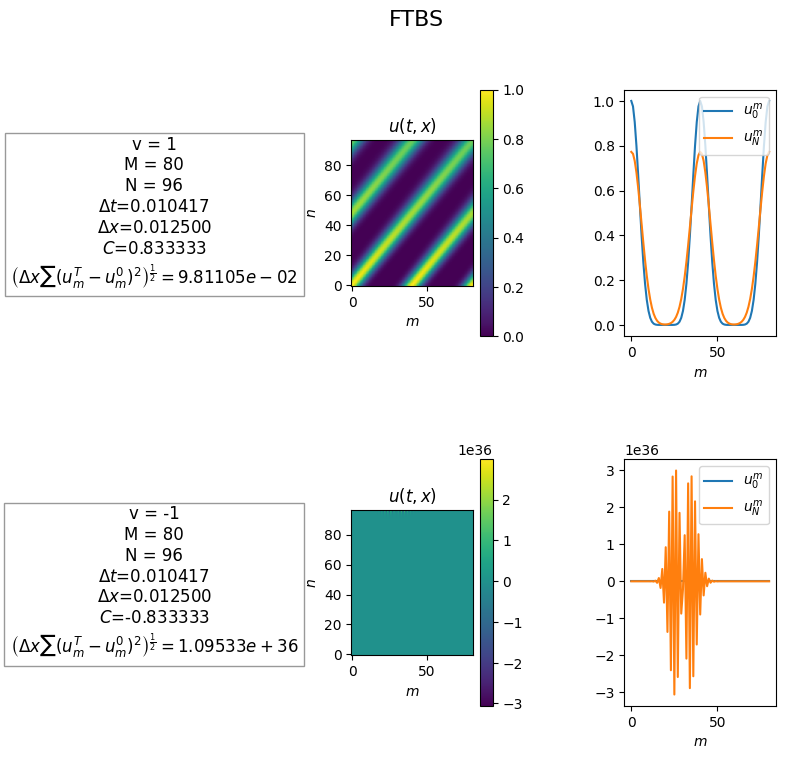

In [2]:
time_domains = [
    DiscreteTimeDomain(t_0=0, T=1, N=int(5 * 1.2 * 2**4)),
    DiscreteTimeDomain(t_0=0, T=1, N=int(5 * 1.2 * 2**4)),
]

space_domains = [
    DiscreteSpaceDomain(a=0, b=1, M=5 * 2**4),
    DiscreteSpaceDomain(a=0, b=1, M=5 * 2**4),
]

velocities = [1, -1]


def u0_cos8(x: np.ndarray):
    return np.cos(2 * np.pi * x) ** 8


# FTBS
plot_experiments(FTBS(), u0_cos8, time_domains[:7], space_domains, velocities, "FTBS")

### Estabilidade - FTCS

Pelos experimentos abaixo, é possível observar que o método não é estável e não converge, conforme esperado de acordo com a análise da estabilidade do método, na qual observamos que

$$
g(\xi,\Delta t, \Delta x) = 1 - iv \frac{\Delta t}{\Delta x}\sin{(\xi \Delta x)}\\
|g|^2 = 1 + \left( v\frac{\Delta t}{\Delta x} \sin{(\xi \Delta x)}\right)^2
$$

Ou seja, $|g|>1$ para qualquer valor de $\xi\ne0, \Delta t >0, \Delta x>0, v\ne0$


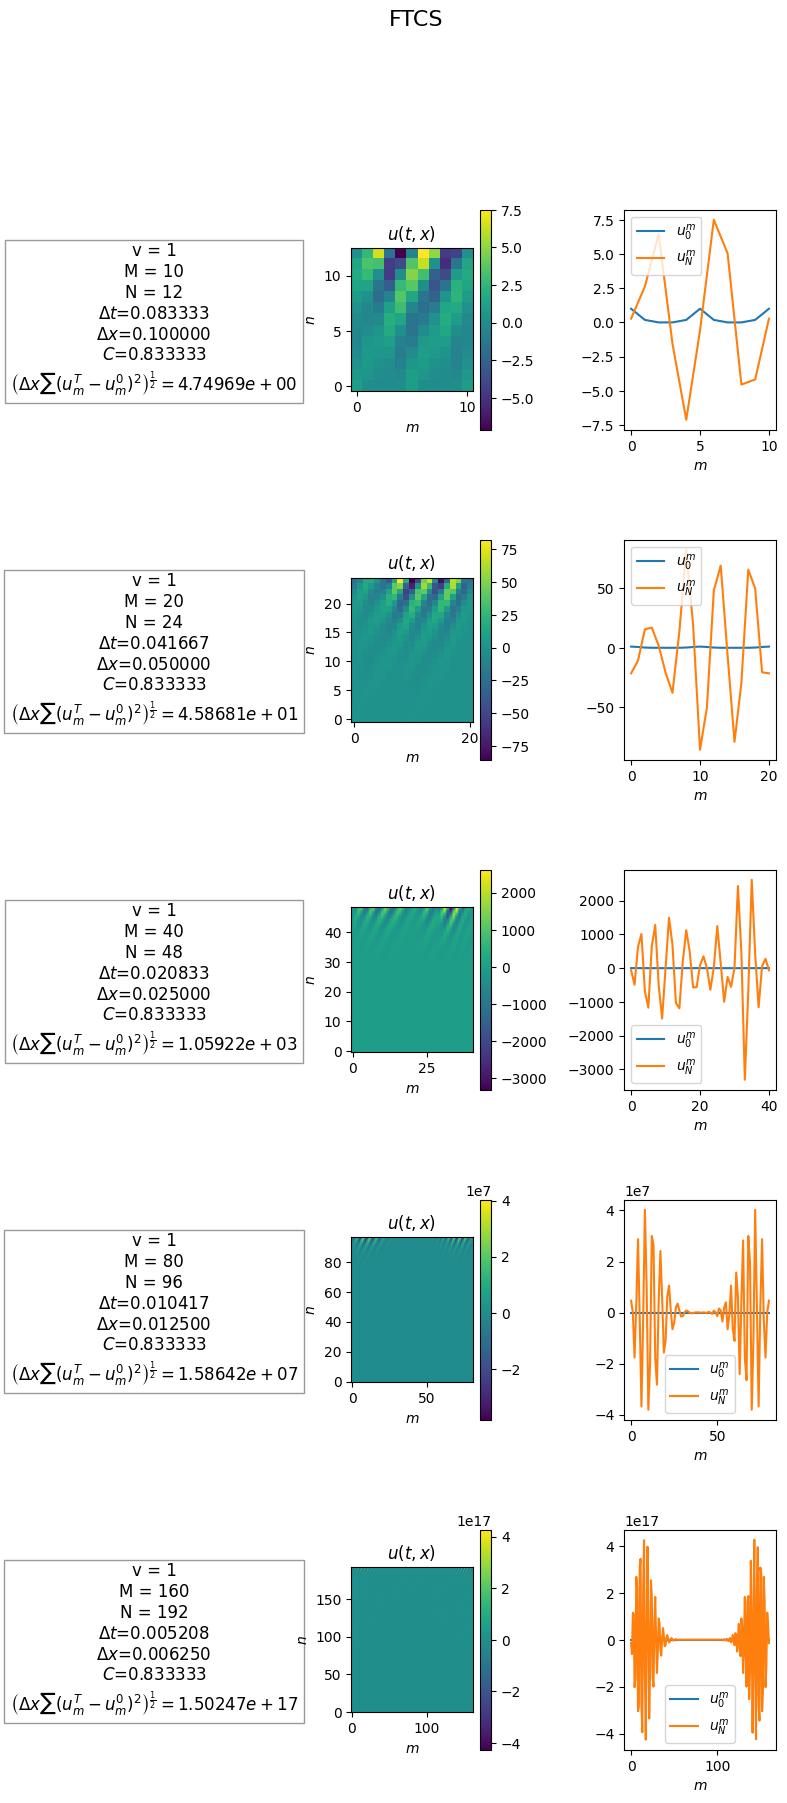

In [3]:
time_domains = [
    DiscreteTimeDomain(t_0=0, T=1, N=int(5 * 1.2 * 2**i)) for i in range(1, 6)
]

space_domains = [DiscreteSpaceDomain(a=0, b=1, M=5 * 2**i) for i in range(1, 6)]

velocities = [1] * len(time_domains)


def u0_cos8(x: np.ndarray):
    return np.cos(2 * np.pi * x) ** 8


# FTCS
plot_experiments(FTCS(), u0_cos8, time_domains, space_domains, velocities, "FTCS")

### Estabilidade - CTCS

Para verificar a estabilidade desse método, foram utilizadas velocidades positivas, pois o método foi implementado com um passo FTBS de inicialização. Pelos experimentos abaixo, é possível observar que, apesar de não ser estável, a solução numérica obtida por esse método aproxima a solução analítica conforme $\Delta x, \Delta t \to 0$


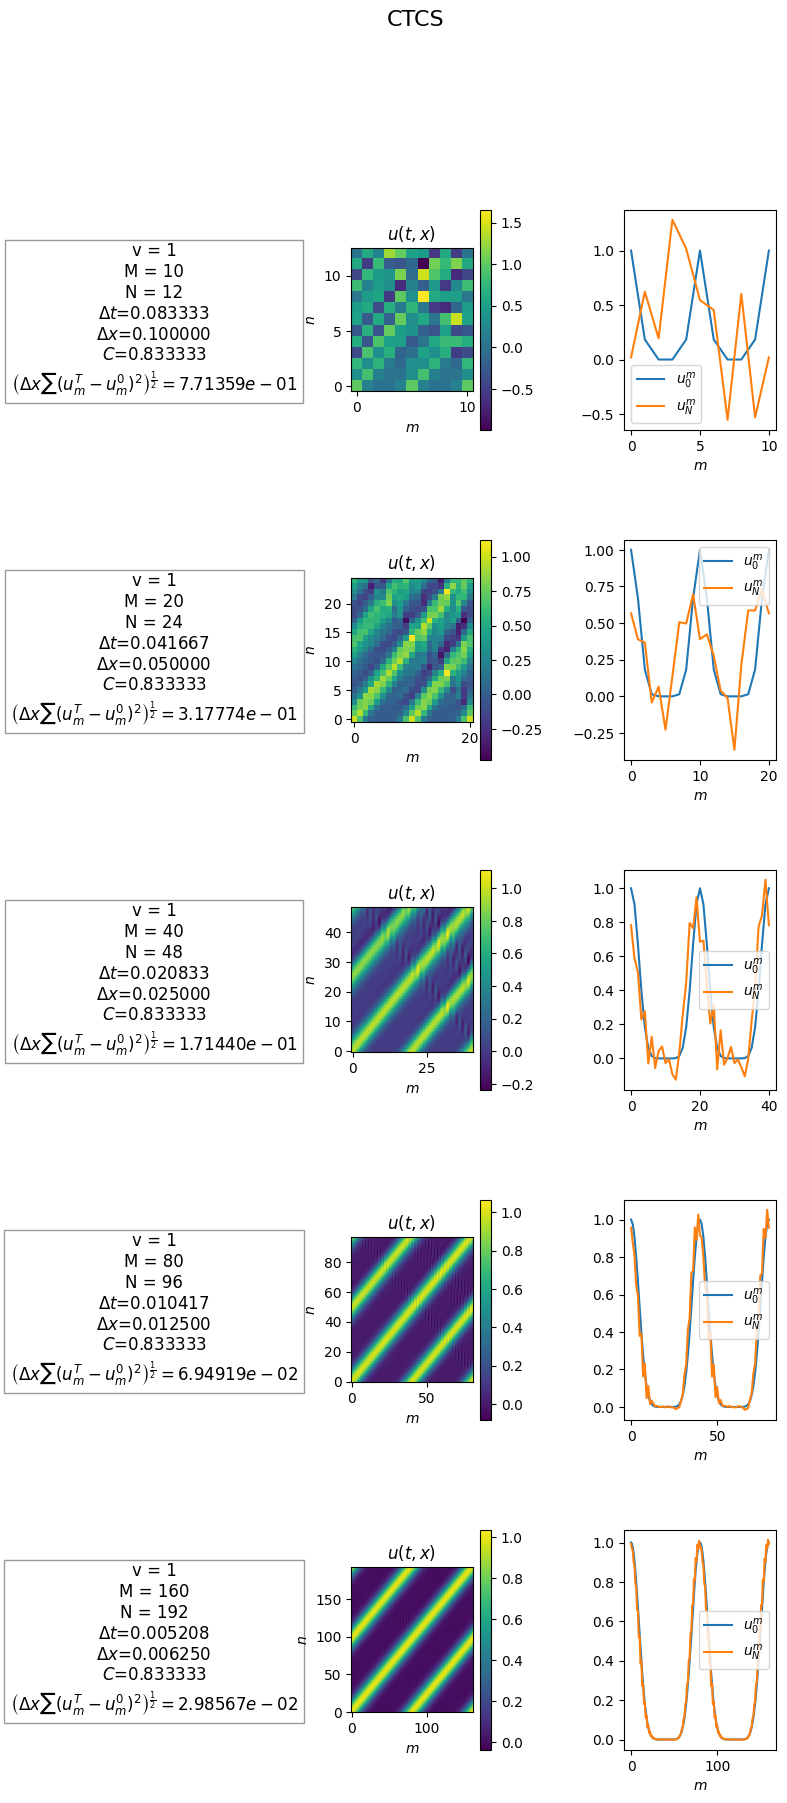

In [4]:
time_domains = [
    DiscreteTimeDomain(t_0=0, T=1, N=int(5 * 1.2 * 2**i)) for i in range(1, 6)
]

space_domains = [DiscreteSpaceDomain(a=0, b=1, M=5 * 2**i) for i in range(1, 6)]

velocities = [1] * len(time_domains)


def u0_cos8(x: np.ndarray):
    return np.cos(2 * np.pi * x) ** 8


# CTCS
plot_experiments(CTCS(), u0_cos8, time_domains, space_domains, velocities, "CTCS")

### Estabilidade - Lax-Wendroff

Para esse método, o fator de amplificação é

$$
g(\xi \Delta x) = 1 - i v \frac{\Delta t}{\Delta x} \sin(\xi \Delta x) - v^2 \frac{\Delta t^2}{\Delta x^2} \left( 1 - \cos(\xi \Delta x) \right)
$$

O que significa que esse método é estável desde que $\frac{v\Delta t}{\Delta x} \le 1$, o que corresponde à condição de CFL para o método. Abaixo, alguns experimentos mostram a execução desse método para números de Courant acima e abaixo de 1. É possível observar que o erro chega próximo a 0 conforme o número de courant se aproxima de 1 (por baixo), e a solução se torna instável quando o número de Courant passa de 1.


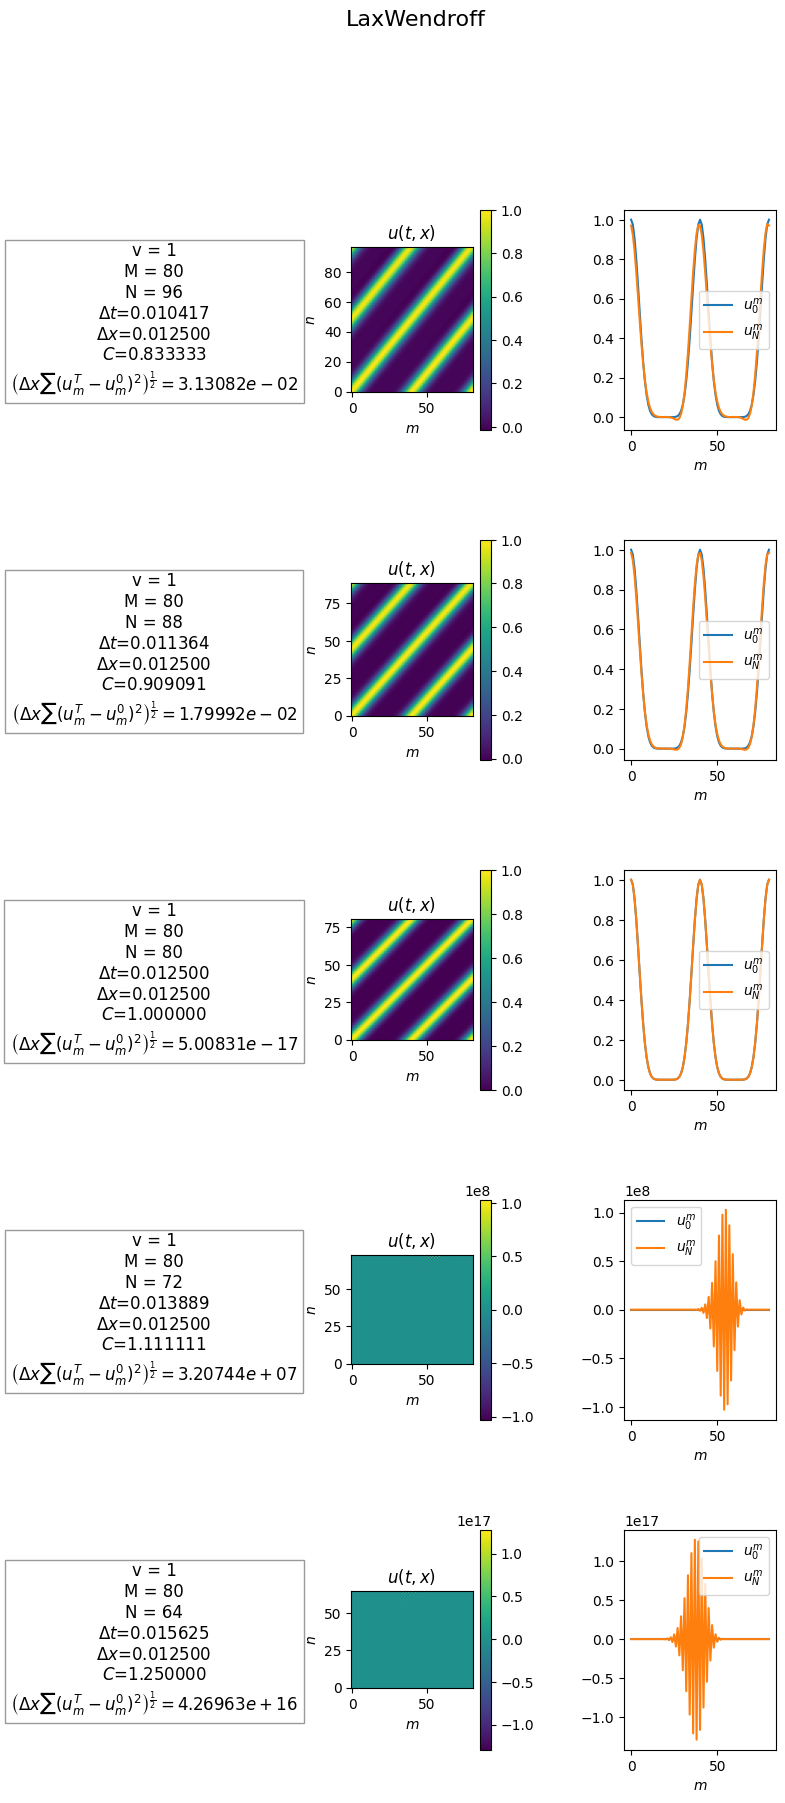

In [5]:
time_domains = [
    DiscreteTimeDomain(t_0=0, T=1, N=int(5 * 1.2 * 2**4)),
    DiscreteTimeDomain(t_0=0, T=1, N=int(5 * 1.1 * 2**4)),
    DiscreteTimeDomain(t_0=0, T=1, N=int(5 * 1.0 * 2**4)),
    DiscreteTimeDomain(t_0=0, T=1, N=int(5 * 0.9 * 2**4)),
    DiscreteTimeDomain(t_0=0, T=1, N=int(5 * 0.8 * 2**4)),
]

space_domains = [
    DiscreteSpaceDomain(a=0, b=1, M=5 * 2**4),
    DiscreteSpaceDomain(a=0, b=1, M=5 * 2**4),
    DiscreteSpaceDomain(a=0, b=1, M=5 * 2**4),
    DiscreteSpaceDomain(a=0, b=1, M=5 * 2**4),
    DiscreteSpaceDomain(a=0, b=1, M=5 * 2**4),
]

velocities = [1] * len(time_domains)


def u0_cos8(x: np.ndarray):
    return np.cos(2 * np.pi * x) ** 8


# CTCS
plot_experiments(
    LaxWendroff(),
    u0_cos8,
    time_domains,
    space_domains,
    velocities,
    "LaxWendroff",
)

## Convergência

Analisar a convergência de um método diretamente nem sempre é prático. Porém, de acordo com o teorema de Lax-Richmyer, se um esquema numérico é consistente, com condição inicial consistente, o esquema é convergente se, e somente se, o esquema é estável. Para esses casos, a ordem de convergência também irá seguir a ordem de consistência. Os experimentos abaixo demonstram a ordem de convergência dos métodos, variando $\Delta x$ e $\Delta t$ de forma a manter o número de Courant constante, e mostrando que o valor da norma $L_2$ do erro cai conforme a ordem de consistência (observar última coluna das tabelas, que mostra a razão do erro atual com relação ao erro anterior).

Foi possível notar que, reduzindo $\Delta t$ e $\Delta x$ pela metade a cada simulação, o erro diminuiu aproximadamente pela metade, cada vez chegando mais próximo de diminuir exatamente pela metade.


In [6]:
time_domains = [
    DiscreteTimeDomain(t_0=0, T=1, N=int(5 * 1.2 * 2**i)) for i in range(1, 13)
]

space_domains = [DiscreteSpaceDomain(a=0, b=1, M=5 * 2**i) for i in range(1, 13)]

velocities_backward = [1] * len(time_domains)
velocities_forward = [-1] * len(time_domains)

### Convergência - FTFS


In [7]:
print_convergence(
    FTFS(), u0_cos8, time_domains, space_domains, velocities_forward, "FTFS"
)


=== FTFS ===
          dt        dx  Courant N.o  Error [L2 norm] Error ratio
0   0.083333  0.100000     0.833333         0.366549            
1   0.041667  0.050000     0.833333         0.240456       0.656
2   0.020833  0.025000     0.833333         0.159376    0.662807
3   0.010417  0.012500     0.833333         0.098111     0.61559
4   0.005208  0.006250     0.833333         0.056058    0.571371
5   0.002604  0.003125     0.833333         0.030282    0.540194
6   0.001302  0.001563     0.833333         0.015790     0.52142
7   0.000651  0.000781     0.833333         0.008070     0.51107
8   0.000326  0.000391     0.833333         0.004080    0.505629
9   0.000163  0.000195     0.833333         0.002052    0.502839
10  0.000081  0.000098     0.833333         0.001029    0.501425
11  0.000041  0.000049     0.833333         0.000515    0.500714


### Convergência - FTBS


In [8]:
print_convergence(
    FTBS(), u0_cos8, time_domains, space_domains, velocities_backward, "FTBS"
)


=== FTBS ===
          dt        dx  Courant N.o  Error [L2 norm] Error ratio
0   0.083333  0.100000     0.833333         0.366549            
1   0.041667  0.050000     0.833333         0.240456       0.656
2   0.020833  0.025000     0.833333         0.159376    0.662807
3   0.010417  0.012500     0.833333         0.098111     0.61559
4   0.005208  0.006250     0.833333         0.056058    0.571371
5   0.002604  0.003125     0.833333         0.030282    0.540194
6   0.001302  0.001563     0.833333         0.015790     0.52142
7   0.000651  0.000781     0.833333         0.008070     0.51107
8   0.000326  0.000391     0.833333         0.004080    0.505629
9   0.000163  0.000195     0.833333         0.002052    0.502839
10  0.000081  0.000098     0.833333         0.001029    0.501425
11  0.000041  0.000049     0.833333         0.000515    0.500714


### Convergência - FTCS


In [9]:
print_convergence(
    FTCS(),
    u0_cos8,
    time_domains[:7],
    space_domains[:7],
    velocities_forward[:7],
    "FTCS",
)


=== FTCS ===
         dt        dx  Courant N.o  Error [L2 norm]  \
0  0.083333  0.100000     0.833333     4.749692e+00   
1  0.041667  0.050000     0.833333     4.586814e+01   
2  0.020833  0.025000     0.833333     1.059218e+03   
3  0.010417  0.012500     0.833333     1.586422e+07   
4  0.005208  0.006250     0.833333     1.502465e+17   
5  0.002604  0.003125     0.833333     1.506648e+38   
6  0.001302  0.001563     0.833333     1.488568e+81   

                                     Error ratio  
0                                                 
1                                       9.657076  
2                                      23.092667  
3                                   14977.303148  
4                              9470775563.826376  
5                       1002784328127073353728.0  
6  9879993075878732111169413422590101358116864.0  


### Convergência - CTCS


In [10]:
print_convergence(
    CTCS(), u0_cos8, time_domains, space_domains, velocities_forward, "CTCS"
)


=== CTCS ===
          dt        dx  Courant N.o  Error [L2 norm] Error ratio
0   0.083333  0.100000     0.833333         1.078947            
1   0.041667  0.050000     0.833333         0.468968    0.434654
2   0.020833  0.025000     0.833333         0.187279    0.399343
3   0.010417  0.012500     0.833333         0.070022    0.373892
4   0.005208  0.006250     0.833333         0.029827     0.42596
5   0.002604  0.003125     0.833333         0.013760    0.461338
6   0.001302  0.001563     0.833333         0.006609    0.480331
7   0.000651  0.000781     0.833333         0.003240    0.490188
8   0.000326  0.000391     0.833333         0.001604    0.495121
9   0.000163  0.000195     0.833333         0.000798    0.497571
10  0.000081  0.000098     0.833333         0.000398    0.498788
11  0.000041  0.000049     0.833333         0.000199    0.499395


### Convergência - Lax Friedrichs


In [11]:
print_convergence(
    LaxFriedrichs(),
    u0_cos8,
    time_domains,
    space_domains,
    velocities_forward,
    "LaxFriedrichs",
)


=== LaxFriedrichs ===
          dt        dx  Courant N.o  Error [L2 norm] Error ratio
0   0.083333  0.100000     0.833333         0.407603            
1   0.041667  0.050000     0.833333         0.324099    0.795136
2   0.020833  0.025000     0.833333         0.237230    0.731966
3   0.010417  0.012500     0.833333         0.163064    0.687369
4   0.005208  0.006250     0.833333         0.103236    0.633097
5   0.002604  0.003125     0.833333         0.060132    0.582471
6   0.001302  0.001563     0.833333         0.032866    0.546573
7   0.000651  0.000781     0.833333         0.017250     0.52486
8   0.000326  0.000391     0.833333         0.008847    0.512859
9   0.000163  0.000195     0.833333         0.004481    0.506542
10  0.000081  0.000098     0.833333         0.002255      0.5033
11  0.000041  0.000049     0.833333         0.001131    0.501657


### Convergência - Lax Wendroff


In [12]:
print_convergence(
    LaxWendroff(),
    u0_cos8,
    time_domains,
    space_domains,
    velocities_forward,
    "LaxWendroff",
)


=== LaxWendroff ===
          dt        dx  Courant N.o  Error [L2 norm] Error ratio
0   0.083333  0.100000     0.833333         0.348019            
1   0.041667  0.050000     0.833333         0.196350    0.564193
2   0.020833  0.025000     0.833333         0.093505    0.476215
3   0.010417  0.012500     0.833333         0.031308    0.334831
4   0.005208  0.006250     0.833333         0.009476    0.302678
5   0.002604  0.003125     0.833333         0.003075    0.324486
6   0.001302  0.001563     0.833333         0.001128    0.366956
7   0.000651  0.000781     0.833333         0.000466    0.413112
8   0.000326  0.000391     0.833333         0.000210    0.449666
9   0.000163  0.000195     0.833333         0.000099     0.47292
10  0.000081  0.000098     0.833333         0.000048    0.485976
11  0.000041  0.000049     0.833333         0.000024    0.492869


### Convergência - Ordem 2 em $\Delta x$

Para verificar a convergência dos métodos que têm ordem 2 em $\Delta x$, foram feitas simulações com $\Delta t$ pequeno, variando $\Delta x$. É possível notar que, para os métodos Lax Friedrichs e Lax Wendroff, que têm ordem 2 em $\Delta x$, ao diminuir $\Delta x$ pela metade, o erro diminui em aproximadamente 4 vezes.

Também é possível notar que para os primeiros valores de $\Delta x$, o erro para o método de Lax Friedrichs se mantém quase constante. Isso pode ser devido ao fato do erro de truncamento do método Lax Friedrichs ter um termo $u_{xx}\frac{\Delta x ^2}{2 \Delta t}$, que fica alto já que o $\Delta t$ já começa baixo nesses experimentos. Outro fator a levar em conta nesses experimentos é que o número de Courant começa muito menor que 1, o que também pode impactar o resultado e causar esse efeito mencionado no erro.


In [13]:
# Small delta t for all simulations
time_domains = [
    DiscreteTimeDomain(t_0=0, T=1, N=int(5 * 1.2 * 2**11)) for i in range(1, 11)
]

# Varying delta x
space_domains = [DiscreteSpaceDomain(a=0, b=1, M=5 * 2**i) for i in range(1, 11)]

velocities_backward = [1] * len(time_domains)
velocities_forward = [-1] * len(time_domains)

In [14]:
print_convergence(
    LaxFriedrichs(),
    u0_cos8,
    time_domains,
    space_domains,
    velocities_forward,
    "LaxFriedrichs",
)


=== LaxFriedrichs ===
         dt        dx  Courant N.o  Error [L2 norm] Error ratio
0  0.000081  0.100000     0.000814         0.432080            
1  0.000081  0.050000     0.001628         0.383081    0.886598
2  0.000081  0.025000     0.003255         0.366733    0.957326
3  0.000081  0.012500     0.006510         0.358018    0.976237
4  0.000081  0.006250     0.013021         0.353812    0.988249
5  0.000081  0.003125     0.026042         0.351902    0.994603
6  0.000081  0.001563     0.052083         0.325990    0.926365
7  0.000081  0.000781     0.104167         0.202536    0.621294
8  0.000081  0.000391     0.208333         0.085104    0.420194
9  0.000081  0.000195     0.416667         0.022880    0.268841


In [15]:
print_convergence(
    LaxWendroff(),
    u0_cos8,
    time_domains,
    space_domains,
    velocities_forward,
    "LaxWendroff",
)


=== LaxWendroff ===
         dt        dx  Courant N.o  Error [L2 norm] Error ratio
0  0.000081  0.100000     0.000814         0.675615            
1  0.000081  0.050000     0.001628         0.359216    0.531687
2  0.000081  0.025000     0.003255         0.273674    0.761864
3  0.000081  0.012500     0.006510         0.113513    0.414774
4  0.000081  0.006250     0.013021         0.038514    0.339289
5  0.000081  0.003125     0.026042         0.013828    0.359044
6  0.000081  0.001563     0.052083         0.005463    0.395078
7  0.000081  0.000781     0.104167         0.002304    0.421662
8  0.000081  0.000391     0.208333         0.000959    0.416161
9  0.000081  0.000195     0.416667         0.000343    0.357267
